In [1]:
import pandas as pd
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold, ShuffleSplit, GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.dates as mdates
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from PIL import Image, ImageOps
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, ndcg_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from PIL import Image, ImageOps
import lime
import lime.lime_tabular

### Champion Notes:
##### all champs:
- 30/34 champions were top 5 in team_rating_custom
- 31/34 champions were break_even_over500_PD
- last 4 champions were top 4 in team_rating_custom
- last 4 champions were top 6 in sum_mvp_shares_L4S
- last 4 champions were top 6 passing_offense_Y/G
- last 13 champions had 2 or greater passing_offense_GWD
- last 6 champions were top 4 in pso
- every champion, except for Eli Manning's teams was at top 6 or smaller in league in either OSRS or DSRS

In [2]:
df = pd.read_csv("NFL Champion RawData.csv")
df = df.fillna(0)
df.rename(columns={'season': 'Season'}, inplace=True)

df = df[df['make_playoffs'] == 1]
print(list(df.columns))

['Season', 'Team', 'team_id', 'conference', 'divisions', 'round', 'champion_share', 'champion', 'W', 'L', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make_playoffs', 'seed', '1_seed', '2_seed', '3_seed', '4_seed', '5_seed', '6_seed', 'playoff_games', 'playoff_wins', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_offense_EXP'

In [3]:
data_columns = ['W', 'L', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make_playoffs',
                'seed', '1_seed', '2_seed', '3_seed', '4_seed', '5_seed', '6_seed', 'playoff_games', 'playoff_wins', 
                'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 
                'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp',
                'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 
                'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A',
                'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%',
                'team_offense_TO%', 'team_offense_EXP', 'team_defense_PA', 'team_defense_Tot Yds & TO_Yds', 'team_defense_Tot Yds & TO_Ply',
                'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD',
                'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Yds', 'team_defense_Passing_TD', 
                'team_defense_Passing_Int', 'team_defense_Passing_NY/A', 'team_defense_Passing_1stD', 'team_defense_Passing_Att', 
                'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A', 'team_defense_Rushing_1stD', 
                'team_defense_Penalties_Pen', 'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 'team_defense_EXP',
                'passing_offense_G', 'passing_offense_Cmp', 'passing_offense_Att', 'passing_offense_Cmp%', 'passing_offense_Yds', 'passing_offense_TD', 'passing_offense_TD%', 
                'passing_offense_Int', 'passing_offense_Int%', 'passing_offense_Lng', 'passing_offense_Y/A', 'passing_offense_AY/A', 'passing_offense_Y/C',
                'passing_offense_Y/G', 'passing_offense_Rate', 'passing_offense_Sk', 'passing_offense_Sk%', 'passing_offense_NY/A', 'passing_offense_ANY/A', 
                'passing_offense_4QC', 'passing_offense_GWD', 'passing_offense_EXP', 'pso', 'over500_rec', 'over600_rec', 'rec_7pt_or_less', 
                'sum_games_7pts_or_less', 'over500_PD', 'sum_mvp_shares', 'sum_dpoy_shares', 'sum_opoy_shares', 'sum_all_pro', 'sum_cpoy_shares', 
                'sum_champion_shares', 'sum_champions', 'sum_playoff_games', 'sum_mvp_shares_L4S', 'sum_dpoy_shares_L4S', 'sum_player_L1S_cs',
                'sum_player_L3S_cs', 'sum_player_L5S_cs', 'sum_player_L8S_cs', 'conference_record', 'divisions_record', 'sum_coach_playoff_games',
                'sum_kicker_playoff_games', '40_50+_perc_x_makes', 'Scoring_FG%', 'Scoring_Lng', 'Scoring_XP%', 'break_even_over500_PD', 
                'sum_QB_playoff_games', 'QB_Age', 'sum_QB_mvp_shares', 'sum_franchise_L1S_cs', 'sum_franchise_L3S_cs', 'sum_franchise_L5S_cs', 'sum_franchise_L8S_cs', 'team_rating_custom', 'QB_2_or_more_GWD', '500_rec_7pt_or_less', '625_rec',  'SRS_greater_than_1.5_pts', 'team_rating_custom', 'rank_team_rating_custom', 'top_5_team_rating_custom']

df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

In [4]:
correlation_matrix = data.corr()

correlation_threshold = .75

columns_to_remove = set()
#print("Columns to be Removed:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)
                #print(f"{feature_j} (correlated with {feature_i}): {correlation:.2f}")

data_filtered = data.drop(columns=columns_to_remove)

In [5]:
print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))

Columns in data_filtered:
'W', 'PF', 'PA', 'PD', 'SoS', 'make_playoffs', 'seed', '1_seed', '2_seed', '3_seed', '4_seed', '5_seed', '6_seed', 'playoff_games', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Passing_NY/A', 'team_offense_Passing_Att', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_EXP', 'team_defense_Tot Yds & TO_Ply', 'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD', 'team_defense_Tot Yds & TO_Cmp', 'team_defense_Passing_TD', 'team_defense_Passing_Att', 'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Penalties_Pen', 'team_defense_Penalties_1stPy', 'team_defense_EXP', 'passing_offense_G', 'passing_offense_Cmp%', 'passing_offense_TD%', 'passing_offense_Lng', 'passing_offense_Y/C'

In [25]:
features = ['40_50+_perc_x_makes', 'sum_kicker_playoff_games', 'sum_QB_playoff_games', 'top_5_team_rating_custom', 
           'sum_coach_playoff_games', 'sum_dpoy_shares', 'sum_cpoy_shares', 'sum_champions', 'sum_all_pro', 'sum_QB_mvp_shares',
            
            'SoS', 'pso',
           'team_offense_Tot Yds & TO_TO', 'team_offense_Passing_Att', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Penalties_Pen' , 'team_offense_Penalties_1stPy',
           'team_offense_TO%', 'team_defense_Tot Yds & TO_Ply', 'team_defense_Rushing_Yds', 'passing_offense_Lng', 'passing_offense_Y/C',
            'passing_offense_Sk', 'passing_offense_4QC', 'sum_mvp_shares', 'DSRS', 'OSRS',
           
             'team_defense_EXP', 'sum_playoff_games', 'team_offense_EXP', 'sum_opoy_shares', 'sum_player_L3S_cs'
           ]

            
num_features = len(features)

print(f"Number of features: {num_features}")



Number of features: 33


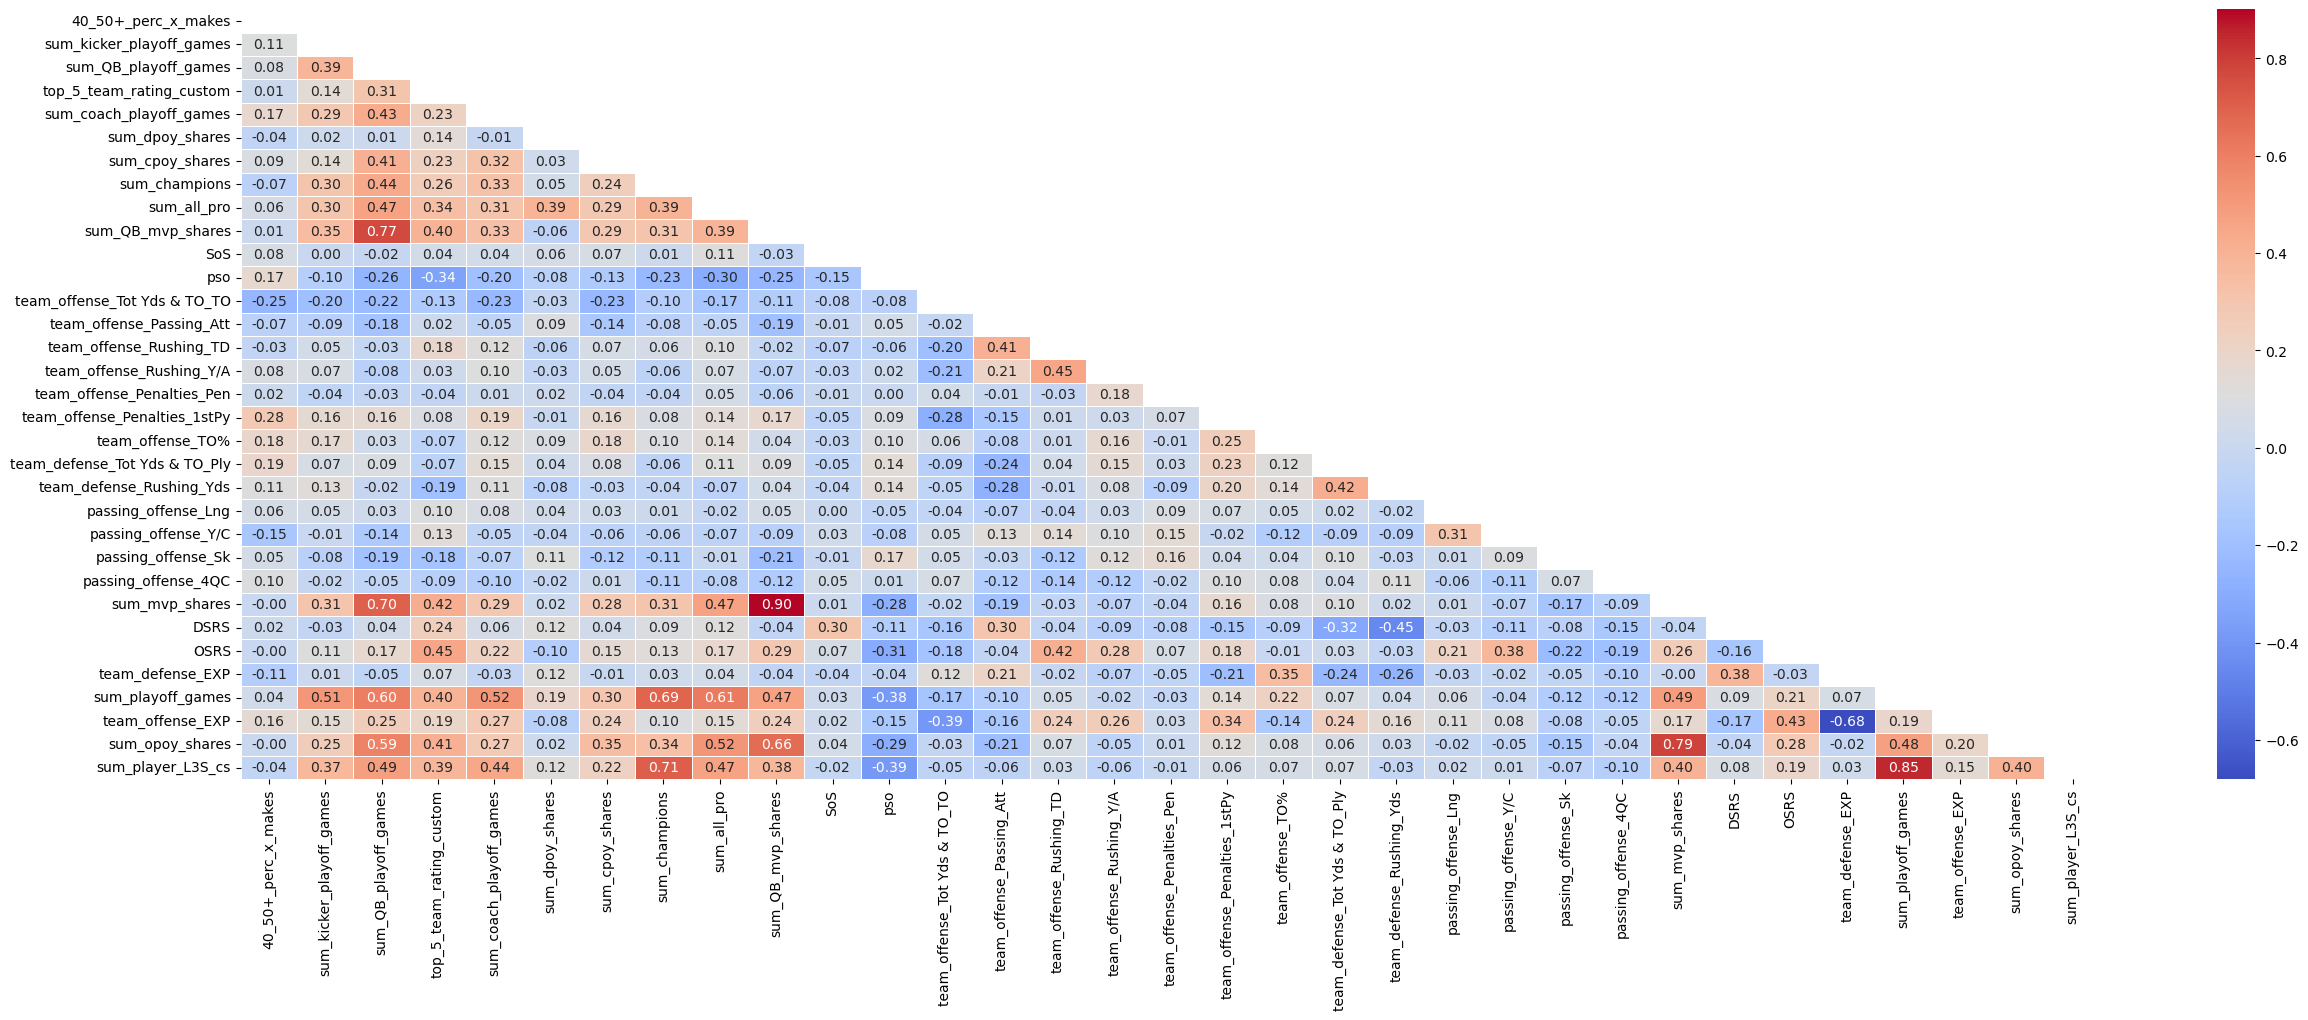

In [26]:
selected_features_data = data[features]
correlation_matrix = selected_features_data.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(30, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, mask=mask)
plt.show()

### Ridge Regression:

Results:

    Season                  Team  champion_share  predicted_cs
14    2024   San Francisco 49ers            0.75      0.697486
21    2024      Baltimore Ravens            0.50      0.639752
8     2024    Kansas City Chiefs            1.00      0.415635
15    2024        Dallas Cowboys            0.00      0.404110
13    2024         Detroit Lions            0.50      0.334032
0     2024      Cleveland Browns            0.00      0.322136
11    2024        Miami Dolphins            0.00      0.262067
9     2024         Buffalo Bills            0.25      0.241588
10    2024   Philadelphia Eagles            0.00      0.218852
1     2024      Los Angeles Rams            0.00      0.185357
19    2024        Houston Texans            0.25      0.048803
2     2024   Pittsburgh Steelers            0.00      0.036085
27    2024     Green Bay Packers            0.25      0.019412
30    2024  Tampa Bay Buccaneers            0.25      0.002462
---------------------------------------------

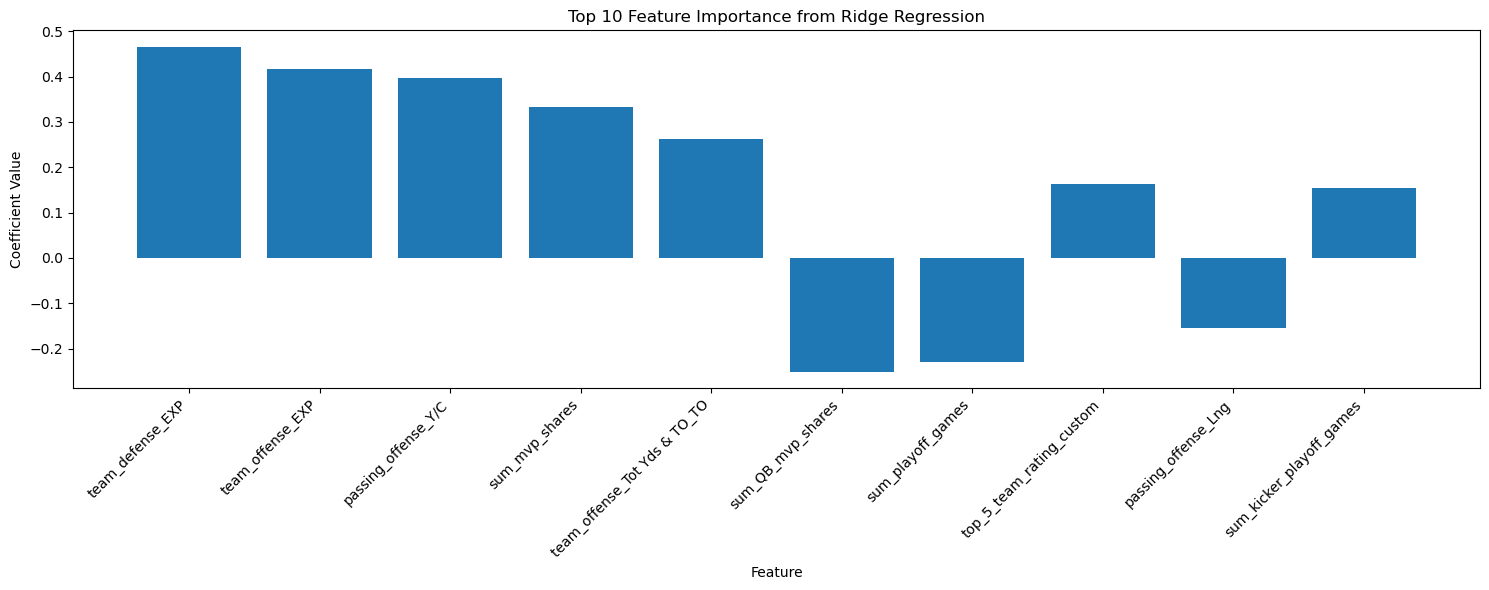

In [27]:
df = pd.read_csv("NFL Champion RawData.csv")
df = df.fillna(0)
df.rename(columns={'season': 'Season'}, inplace=True)

df = df[df['make_playoffs'] == 1]

df.drop(df[df['Season'] < 2006].index, inplace=True)


train = df[df["Season"] < 2024].copy()
test = df[df["Season"] == 2024].copy()


sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

rig = Ridge(alpha=0.5)
rig.fit(train[features], train["champion_share"])

predictions = rig.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

print("Results:")
print("=============================================================================\n")
print(frame.head(14))
print("-----------------------------------------------------------------------------\n")

def ndcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        dcg = np.sum(r / np.log2(np.arange(2, r.size + 2)))
        idcg = np.sum(np.sort(r)[::-1] / np.log2(np.arange(2, r.size + 2)))
        return dcg / idcg
    return 0.

def calculate_ndcg(df, k=14):
    true_relevance = df['champion_share'].values
    return ndcg_at_k(true_relevance, k)

ndcg_score_true = calculate_ndcg(frame, k=14)

print("NDCG Scores: ")
print("=============================================================================\n")
print("True NDCG @: ", ndcg_score_true)
print("-----------------------------------------------------------------------------\n")

coefficients = rig.coef_
feature_coefficients = dict(zip(features, coefficients))
sorted_feature_coefficients = sorted(feature_coefficients.items(), key=lambda x: abs(x[1]), reverse=True)

top_features = sorted_feature_coefficients[:10]
features_names = [x[0] for x in top_features]
coeff_values = [x[1] for x in top_features]

plt.figure(figsize=(15, 6))
plt.bar(features_names, coeff_values)
plt.title('Top 10 Feature Importance from Ridge Regression')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

predictions = rig.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
rig_reg_frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
rig_reg_frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

In [28]:
actual = frame.sort_values("champion_share", ascending=False)
predicted = frame.sort_values("predicted_cs", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame):
    actual = frame.sort_values("champion_share", ascending=False).head(1) #HEAD

    predicted = frame.sort_values("predicted_cs", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame)
print("=============================================================================\n")
print("AP Champion: ", ap)

Ranking Accuracy (Champion):

   Season_x                Team  champion_share_x  predicted_cs_x  Rank  Season_y  champion_share_y  predicted_cs_y  Predicted Rank
0      2024  Kansas City Chiefs               1.0        0.415635     1      2024               1.0        0.415635               3

AP Champion:  0.3333333333333333


In [29]:
rig_reg_combined_predictions = pd.DataFrame(columns=["Season","Team", "predicted_cs", "champion_share"])

all_predictions = []
aps = []
ndcgs = []

#backtest_seasons = [2023,2022,2021,2020]
backtest_seasons = [2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011]

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rig.fit(train[features], train['champion_share'])
    predictions = rig.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
    frame = pd.concat([test[["Team", "champion_share", "Season"]], predictions_df], axis=1)

    frame['Team/Season'] = frame['Team'] + ' ' + frame['Season'].astype(str)

    rig_reg_combined_predictions = pd.concat([rig_reg_combined_predictions, frame], ignore_index=True)

    if not frame.empty:
        all_predictions.append(frame)
        ap = find_ap(frame)
        aps.append(ap)

        ndcg = ndcg_score(frame["champion_share"].values.reshape(1, -1), predictions.reshape(1, -1))
        ndcgs.append(ndcg)

        reciprocal_ap = 1 / ap
        print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)} | NDCG: {round(ndcg, 2)}")
    else:
        print(f"No data for Season {season}")

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted_cs", ascending=False).head(10)

    print(f"\nTop 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted_cs", "champion_share"]])

average_ndcg = np.mean(ndcgs)
average_ap = np.mean(aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_ndcg = 1.0 / average_ndcg

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average Champion Rank: {round(reciprocal_average_ap, 2)} | Reciprocal NDCG: {round(reciprocal_ndcg, 2)}")
print(f"Min Champion Rank: {round(reciprocal_min_ap, 2)}")
print(f"Max Champion Rank: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

rig_reg_combined_predictions.to_csv("rig_reg_nfl_preds.csv", index=False)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Champion AP for Season 2024: 0.33 | Reciprocal: 3.0 | NDCG: 0.89
Champion AP for Season 2023: 1.0 | Reciprocal: 1.0 | NDCG: 0.99
Champion AP for Season 2022: 0.5 | Reciprocal: 2.0 | NDCG: 0.77
Champion AP for Season 2021: 1.0 | Reciprocal: 1.0 | NDCG: 0.87
Champion AP for Season 2020: 0.5 | Reciprocal: 2.0 | NDCG: 0.71
Champion AP for Season 2019: 1.0 | Reciprocal: 1.0 | NDCG: 0.9
Champion AP for Season 2018: 0.5 | Reciprocal: 2.0 | NDCG: 0.89
Champion AP for Season 2017: 1.0 | Reciprocal: 1.0 | NDCG: 0.93
Champion AP for Season 2016: 1.0 | Reciprocal: 1.0 | NDCG: 0.96
Champion AP for Season 2015: 0.33 | Reciprocal: 3.0 | NDCG: 0.66
Champion AP for Season 2014: 0.2 | Reciprocal: 5.0 | NDCG: 0.8
Champion AP for Season 2013: 0.25 | Reciprocal: 4.0 | NDCG: 0.72
Champion AP for Season 2012: 0.25 | Reciprocal: 4.0 | NDCG: 0.83
Champion AP for Season 2011: 0.2 | Reciprocal: 5.0 | NDCG: 0.63

Top 5 Predicted Teams for Season 2024:
                   Team  predicted_cs  champion_share
14  San 

### Random-Forest Regression:

In [12]:
df = pd.read_csv("NFL Champion RawData.csv")
df = df.fillna(0)
df.rename(columns={'season': 'Season'}, inplace=True)

df = df[df['make_playoffs'] == 1]
print(list(df.columns))

['Season', 'Team', 'team_id', 'conference', 'divisions', 'round', 'champion_share', 'champion', 'W', 'L', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make_playoffs', 'seed', '1_seed', '2_seed', '3_seed', '4_seed', '5_seed', '6_seed', 'playoff_games', 'playoff_wins', 'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_offense_EXP'

In [13]:
data_columns = ['W', 'L', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS', 'OSRS', 'DSRS', 'make_playoffs',
                'seed', '1_seed', '2_seed', '3_seed', '4_seed', '5_seed', '6_seed', 'playoff_games', 'playoff_wins', 
                'team_offense_PF', 'team_offense_Tot Yds & TO_Yds', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 
                'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp',
                'team_offense_Tot Yds & TO_Att', 'team_offense_Passing_Yds', 'team_offense_Passing_TD', 'team_offense_Passing_Int', 'team_offense_Passing_NY/A', 
                'team_offense_Passing_1stD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A',
                'team_offense_Rushing_1stD', 'team_offense_Penalties_Pen', 'team_offense_Penalties_Yds', 'team_offense_Penalties_1stPy', 'team_offense_Sc%',
                'team_offense_TO%', 'team_offense_EXP', 'team_defense_PA', 'team_defense_Tot Yds & TO_Yds', 'team_defense_Tot Yds & TO_Ply',
                'team_defense_Tot Yds & TO_Y/P', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_1stD',
                'team_defense_Tot Yds & TO_Cmp', 'team_defense_Tot Yds & TO_Att', 'team_defense_Passing_Yds', 'team_defense_Passing_TD', 
                'team_defense_Passing_Int', 'team_defense_Passing_NY/A', 'team_defense_Passing_1stD', 'team_defense_Passing_Att', 
                'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Rushing_Y/A', 'team_defense_Rushing_1stD', 
                'team_defense_Penalties_Pen', 'team_defense_Penalties_Yds', 'team_defense_Penalties_1stPy', 'team_defense_Sc%', 'team_defense_TO%', 'team_defense_EXP',
                'passing_offense_G', 'passing_offense_Cmp', 'passing_offense_Att', 'passing_offense_Cmp%', 'passing_offense_Yds', 'passing_offense_TD', 'passing_offense_TD%', 
                'passing_offense_Int', 'passing_offense_Int%', 'passing_offense_Lng', 'passing_offense_Y/A', 'passing_offense_AY/A', 'passing_offense_Y/C',
                'passing_offense_Y/G', 'passing_offense_Rate', 'passing_offense_Sk', 'passing_offense_Sk%', 'passing_offense_NY/A', 'passing_offense_ANY/A', 
                'passing_offense_4QC', 'passing_offense_GWD', 'passing_offense_EXP', 'pso', 'over500_rec', 'over600_rec', 'rec_7pt_or_less', 
                'sum_games_7pts_or_less', 'over500_PD', 'sum_mvp_shares', 'sum_dpoy_shares', 'sum_opoy_shares', 'sum_all_pro', 'sum_cpoy_shares', 
                'sum_champion_shares', 'sum_champions', 'sum_playoff_games', 'sum_mvp_shares_L4S', 'sum_dpoy_shares_L4S', 'sum_player_L1S_cs',
                'sum_player_L3S_cs', 'sum_player_L5S_cs', 'sum_player_L8S_cs', 'conference_record', 'divisions_record', 'sum_coach_playoff_games',
                'sum_kicker_playoff_games', '40_50+_perc_x_makes', 'Scoring_FG%', 'Scoring_Lng', 'Scoring_XP%', 'break_even_over500_PD', 
                'sum_QB_playoff_games', 'QB_Age', 'sum_QB_mvp_shares', 'sum_franchise_L1S_cs', 'sum_franchise_L3S_cs', 'sum_franchise_L5S_cs', 'sum_franchise_L8S_cs', 'QB_2_or_more_GWD', '500_rec_7pt_or_less', '625_rec', 'SRS_greater_than_1.5_pts', 'team_rating_custom', 'rank_team_rating_custom', 'top_5_team_rating_custom']

df= df.dropna(subset=data_columns)
data = df[data_columns].copy()

In [14]:
correlation_matrix = data.corr()

correlation_threshold = .8

columns_to_remove = set()
#print("Columns to be Removed:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > correlation_threshold:
            feature_i = correlation_matrix.columns[i]
            feature_j = correlation_matrix.columns[j]
            if feature_i not in columns_to_remove:
                columns_to_remove.add(feature_j)
                #print(f"{feature_j} (correlated with {feature_i}): {correlation:.2f}")

data_filtered = data.drop(columns=columns_to_remove)

In [15]:
print("Columns in data_filtered:")
print(", ".join(f"'{column}'" for column in data_filtered.columns))

print("\nColumns that were removed:")
print(", ".join(f"'{removed_column}'" for removed_column in columns_to_remove))

Columns in data_filtered:
'W', 'PF', 'PA', 'PD', 'SoS', 'make_playoffs', 'seed', '1_seed', '2_seed', '3_seed', '4_seed', '5_seed', '6_seed', 'playoff_games', 'team_offense_Tot Yds & TO_Ply', 'team_offense_Tot Yds & TO_Y/P', 'team_offense_Tot Yds & TO_TO', 'team_offense_Tot Yds & TO_FL', 'team_offense_Tot Yds & TO_1stD', 'team_offense_Tot Yds & TO_Cmp', 'team_offense_Passing_TD', 'team_offense_Passing_Att', 'team_offense_Rushing_Yds', 'team_offense_Rushing_TD', 'team_offense_Rushing_Y/A', 'team_offense_Penalties_Pen', 'team_offense_Penalties_1stPy', 'team_offense_Sc%', 'team_offense_TO%', 'team_offense_EXP', 'team_defense_Tot Yds & TO_Yds', 'team_defense_Tot Yds & TO_Ply', 'team_defense_Tot Yds & TO_TO', 'team_defense_Tot Yds & TO_FL', 'team_defense_Tot Yds & TO_Cmp', 'team_defense_Passing_TD', 'team_defense_Passing_Att', 'team_defense_Rushing_Yds', 'team_defense_Rushing_TD', 'team_defense_Penalties_Pen', 'team_defense_Penalties_1stPy', 'team_defense_EXP', 'passing_offense_G', 'passing_

In [16]:
features = ['break_even_over500_PD', 'conference_record', 'team_rating_custom', 'QB_Age', 'Scoring_FG%', 
            'sum_kicker_playoff_games', 'sum_QB_playoff_games', 'sum_coach_playoff_games', 'sum_mvp_shares', 'sum_dpoy_shares', 'sum_all_pro', 'sum_cpoy_shares',
            'sum_playoff_games', 'sum_champions', 'sum_franchise_L8S_cs', 'SoS', 'pso', 'sum_franchise_L1S_cs',
            'passing_offense_Lng', 'passing_offense_Sk'
           
           
           ]


Results:

    Season                  Team  champion_share  predicted_cs
8     2024    Kansas City Chiefs            1.00      0.643769
14    2024   San Francisco 49ers            0.75      0.638563
21    2024      Baltimore Ravens            0.50      0.529615
15    2024        Dallas Cowboys            0.00      0.474057
2     2024   Pittsburgh Steelers            0.00      0.186924
1     2024      Los Angeles Rams            0.00      0.185065
13    2024         Detroit Lions            0.50      0.184632
0     2024      Cleveland Browns            0.00      0.165388
19    2024        Houston Texans            0.25      0.161663
9     2024         Buffalo Bills            0.25      0.141171
10    2024   Philadelphia Eagles            0.00      0.141087
27    2024     Green Bay Packers            0.25      0.135817
30    2024  Tampa Bay Buccaneers            0.25      0.133895
11    2024        Miami Dolphins            0.00      0.104026
---------------------------------------------

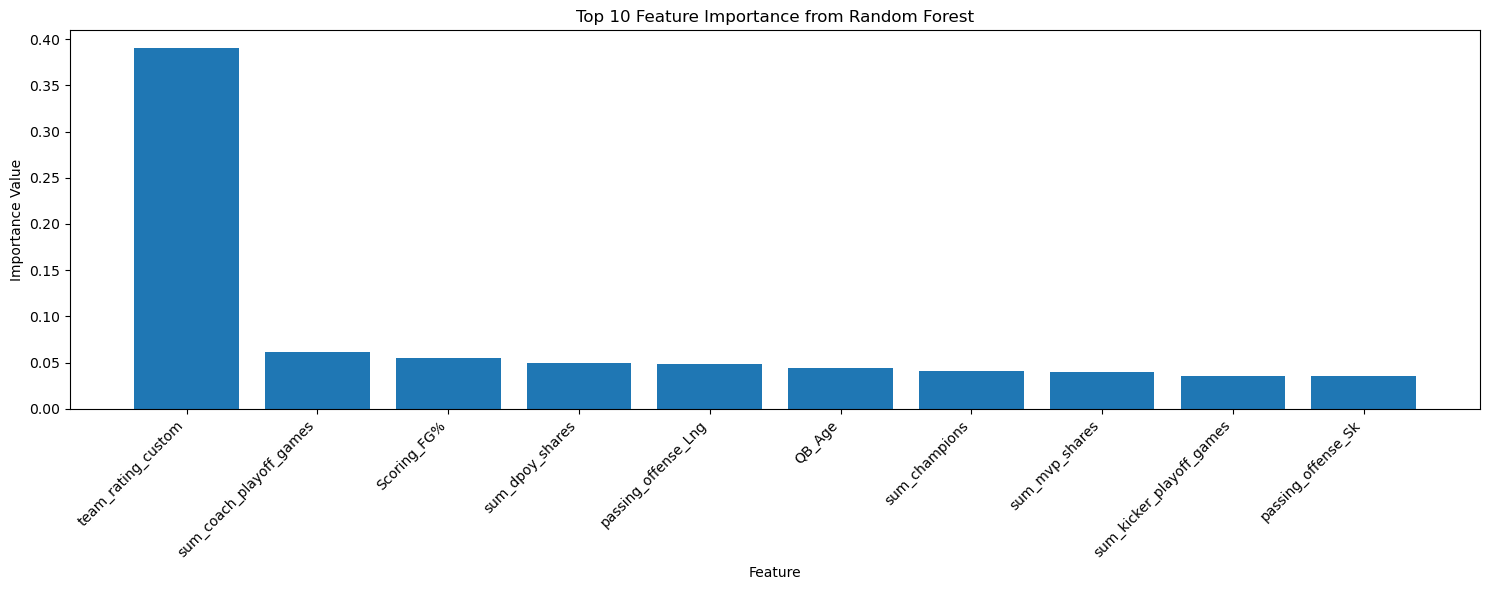

In [17]:
df = pd.read_csv("NFL Champion RawData.csv")
df = df.fillna(0)
df.rename(columns={'season': 'Season'}, inplace=True)

df = df[df['make_playoffs'] == 1]

df.drop(df[df['Season'] < 2006].index, inplace=True)


train = df[df["Season"] < 2024].copy()
test = df[df["Season"] == 2024].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

rf = RandomForestRegressor(
    n_estimators=22,        
    max_depth=5,            
    min_samples_split=5,     
    min_samples_leaf=2,      
    random_state=5          
)
rf.fit(train[features], train["champion_share"])

predictions = rf.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

print("Results:")
print("=============================================================================\n")
print(frame.head(14))
print("-----------------------------------------------------------------------------\n")

def ndcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        dcg = np.sum(r / np.log2(np.arange(2, r.size + 2)))
        idcg = np.sum(np.sort(r)[::-1] / np.log2(np.arange(2, r.size + 2)))
        return dcg / idcg
    return 0.

def calculate_ndcg(df, k=14):
    true_relevance = df['champion_share'].values
    return ndcg_at_k(true_relevance, k)

ndcg_score_true = calculate_ndcg(frame, k=14)

print("NDCG Scores: ")
print("=============================================================================\n")
print("True NDCG @: ", ndcg_score_true)
print("-----------------------------------------------------------------------------\n")

feature_importances = rf.feature_importances_
feature_importance_dict = dict(zip(features, feature_importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

top_features = sorted_feature_importance[:10]
features_names = [x[0] for x in top_features]
importances = [x[1] for x in top_features]

plt.figure(figsize=(15, 6))
plt.bar(features_names, importances)
plt.title('Top 10 Feature Importance from Random Forest')
plt.ylabel('Importance Value')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

predictions = rf.predict(test[features])
predictions = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
rf_reg_frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
rf_reg_frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

In [18]:
actual = frame.sort_values("champion_share", ascending=False)
predicted = frame.sort_values("predicted_cs", ascending=False)
actual["Rank"] = list(range(1, actual.shape[0]+1))
predicted["Predicted Rank"] = list(range(1, predicted.shape[0]+1))

ranking_results = actual.merge(predicted, on="Team").head(1) #HEAD
print("Ranking Accuracy (Champion):")
print("=============================================================================\n")
print(ranking_results.to_string())

# Average Precision Metric
def find_ap(frame):
    actual = frame.sort_values("champion_share", ascending=False).head(1) #HEAD

    predicted = frame.sort_values("predicted_cs", ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row["Team"] in actual["Team"].values:
            found += 1
            ps.append(found / seen)
        seen += 1
    return sum(ps) / len(ps)

ap = find_ap(frame)
print("=============================================================================\n")
print("AP Champion: ", ap)

Ranking Accuracy (Champion):

   Season_x                Team  champion_share_x  predicted_cs_x  Rank  Season_y  champion_share_y  predicted_cs_y  Predicted Rank
0      2024  Kansas City Chiefs               1.0        0.643769     1      2024               1.0        0.643769               1

AP Champion:  1.0


In [20]:
rf_reg_combined_predictions = pd.DataFrame(columns=["Season", "Team", "predicted_cs", "champion_share"])

all_predictions = []
aps = []
ndcgs = []

backtest_seasons = [2024,2023,2022, 2021, 2020,2019,2018,2017,2016,2015,2014,2013,2012,2011]
#backtest_seasons = [2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010]

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion_share'])
    predictions = rf.predict(test[features])
    predictions_df = pd.DataFrame(predictions, columns=["predicted_cs"], index=test.index)
    frame = pd.concat([test[["Team", "champion_share", "Season"]], predictions_df], axis=1)

    frame['Team/Season'] = frame['Team'] + ' ' + frame['Season'].astype(str)

    # Append the predictions for the current season to the combined predictions DataFrame
    rf_reg_combined_predictions = pd.concat([rf_reg_combined_predictions, frame], ignore_index=True)

    if not frame.empty:
        all_predictions.append(frame)
        ap = find_ap(frame)
        aps.append(ap)

        ndcg = ndcg_score(frame["champion_share"].values.reshape(1, -1), predictions.reshape(1, -1))
        ndcgs.append(ndcg)

        reciprocal_ap = 1 / ap
        print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)} | NDCG: {round(ndcg, 2)}")
    else:
        print(f"No data for Season {season}")

for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted_cs", ascending=False).head(10)

    print(f"\nTop 5 Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted_cs", "champion_share"]])

average_ndcg = np.mean(ndcgs)
average_ap = np.mean(aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_ndcg = 1.0 / average_ndcg

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average Champion Rank: {round(reciprocal_average_ap, 2)} | Reciprocal NDCG: {round(reciprocal_ndcg, 2)}")
print(f"Min Champion Rank: {round(reciprocal_min_ap, 2)}")
print(f"Max Champion Rank: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

rf_reg_combined_predictions.to_csv("rf_reg_nfl_preds.csv", index=False)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Champion AP for Season 2024: 1.0 | Reciprocal: 1.0 | NDCG: 0.95
Champion AP for Season 2023: 1.0 | Reciprocal: 1.0 | NDCG: 0.95
Champion AP for Season 2022: 0.17 | Reciprocal: 6.0 | NDCG: 0.7
Champion AP for Season 2021: 0.5 | Reciprocal: 2.0 | NDCG: 0.94
Champion AP for Season 2020: 0.25 | Reciprocal: 4.0 | NDCG: 0.7
Champion AP for Season 2019: 1.0 | Reciprocal: 1.0 | NDCG: 0.95
Champion AP for Season 2018: 0.17 | Reciprocal: 6.0 | NDCG: 0.8
Champion AP for Season 2017: 1.0 | Reciprocal: 1.0 | NDCG: 0.93
Champion AP for Season 2016: 1.0 | Reciprocal: 1.0 | NDCG: 0.95
Champion AP for Season 2015: 0.33 | Reciprocal: 3.0 | NDCG: 0.78
Champion AP for Season 2014: 0.17 | Reciprocal: 6.0 | NDCG: 0.8
Champion AP for Season 2013: 0.2 | Reciprocal: 5.0 | NDCG: 0.74
Champion AP for Season 2012: 0.14 | Reciprocal: 7.0 | NDCG: 0.66
Champion AP for Season 2011: 0.12 | Reciprocal: 8.0 | NDCG: 0.73

Top 5 Predicted Teams for Season 2024:
                   Team  predicted_cs  champion_share
8    Ka

## Model Combination:

In [21]:
train = df[df["Season"] < 2024].copy()
test = df[df["Season"] == 2024].copy()

sc = MinMaxScaler()
sc.fit(train[features])
train[features] = sc.transform(train[features])
test[features] = sc.transform(test[features])

#rf
rf = RandomForestRegressor(
    n_estimators=22,        
    max_depth=5,            
    min_samples_split=5,     
    min_samples_leaf=2,      
    random_state=5          
)
rf.fit(train[features], train["champion_share"])
rf_predictions = rf.predict(test[features])

#ridge
rig = Ridge(alpha=0.5)

rig.fit(train[features], train["champion_share"])
rig_predictions = rig.predict(test[features])

average_predictions = (rf_predictions + rig_predictions) / 2

predictions = pd.DataFrame(average_predictions, columns=["predicted_cs"], index=test.index)
frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

print("Result Preview:")
print("=============================================================================\n")
print(frame.head(14))
print("-----------------------------------------------------------------------------\n")

def ndcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        dcg = np.sum(r / np.log2(np.arange(2, r.size + 2)))
        idcg = np.sum(np.sort(r)[::-1] / np.log2(np.arange(2, r.size + 2)))
        return dcg / idcg
    return 0.

def calculate_ndcg(df, k=14):
    true_relevance = df['champion_share'].values
    return ndcg_at_k(true_relevance, k)

ndcg_score_true = calculate_ndcg(frame, k=14)

print("NDCG Scores: ")
print("=============================================================================\n")
print("True NDCG @: ", ndcg_score_true)
print("-----------------------------------------------------------------------------\n")

predictions = pd.DataFrame(average_predictions, columns=["predicted_cs"], index=test.index)
ensemble_frame = pd.concat([test[["Season", "Team", "champion_share"]], predictions], axis=1)
ensemble_frame.sort_values(["Season", "predicted_cs"], inplace=True, ascending=[False, False])

Result Preview:

    Season                  Team  champion_share  predicted_cs
14    2024   San Francisco 49ers            0.75      0.575503
8     2024    Kansas City Chiefs            1.00      0.557393
21    2024      Baltimore Ravens            0.50      0.488827
9     2024         Buffalo Bills            0.25      0.363651
15    2024        Dallas Cowboys            0.00      0.338627
10    2024   Philadelphia Eagles            0.00      0.297656
27    2024     Green Bay Packers            0.25      0.199565
13    2024         Detroit Lions            0.50      0.184455
19    2024        Houston Texans            0.25      0.165751
2     2024   Pittsburgh Steelers            0.00      0.161699
1     2024      Los Angeles Rams            0.00      0.139590
11    2024        Miami Dolphins            0.00      0.136460
0     2024      Cleveland Browns            0.00      0.124379
30    2024  Tampa Bay Buccaneers            0.25      0.070430
--------------------------------------

In [22]:

combined_predictions = pd.DataFrame(columns=["season", "Team", "predicted_cs", "champion_share"])

all_predictions = []
aps = []
ndcgs = []

#backtest_seasons = [2024,2023,2022,2021,2020]
backtest_seasons = [2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010]

rf = RandomForestRegressor(
    n_estimators=9,        
    max_depth=3,            
    min_samples_split=5,     
    min_samples_leaf=2,      
    random_state=5          
)

for season in backtest_seasons:
    train = df[df["Season"] < season].copy()
    test = df[df["Season"] == season].copy()

    sc = MinMaxScaler()
    sc.fit(train[features])
    train[features] = sc.transform(train[features])
    test[features] = sc.transform(test[features])

    rf.fit(train[features], train['champion_share'])
    rf_predictions = rf.predict(test[features])

    rig.fit(train[features], train['champion_share'])
    rig_predictions = rig.predict(test[features])

    average_predictions = (rf_predictions + rig_predictions) / 2

    predictions_df = pd.DataFrame(average_predictions, columns=["predicted_cs"], index=test.index)
    frame = pd.concat([test[["Team", "champion_share", "Season"]], predictions_df], axis=1)
    frame['Team/Season'] = frame['Team'] + ' ' + frame['Season'].astype(str)

    if not frame.empty:  # Check if frame is not empty before concatenating
        combined_predictions = pd.concat([combined_predictions, frame], ignore_index=True)
        all_predictions.append(frame)
        ap = find_ap(frame)
        aps.append(ap)

        ndcg = ndcg_score(frame["champion_share"].values.reshape(1, -1), average_predictions.reshape(1, -1))  # Use average_predictions instead of frame["predicted champion share"]
        ndcgs.append(ndcg)

        reciprocal_ap = 1 / ap
        print(f"Champion AP for Season {season}: {round(ap, 2)} | Reciprocal: {round(reciprocal_ap, 2)} | NDCG: {round(ndcg, 2)}")
    else:
        print(f"No data for Season {season}")
        
for idx, predictions in enumerate(all_predictions):
    season = backtest_seasons[idx]
    top5_predictions = predictions.sort_values("predicted_cs", ascending=False).head(10)

    print(f"\nTop Predicted Teams for Season {season}:")
    print(top5_predictions[["Team", "predicted_cs", "champion_share"]])

average_ndcg = np.mean(ndcgs)
average_ap = np.mean(aps)

last_n_seasons_aps = aps[-10:]
min_ap = np.min(last_n_seasons_aps)
max_ap = np.max(last_n_seasons_aps)

reciprocal_average_ap = 1.0 / average_ap
reciprocal_min_ap = 1.0 / min_ap
reciprocal_max_ap = 1.0 / max_ap

print("\nAverage Error Metrics Across All Seasons:")
print("=============================================================================")
print(f"Average Champion Rank: {round(reciprocal_average_ap, 2)} | Reciprocal NDCG: {round(average_ndcg, 2)}")  # Change to average_ndcg for NDCG
print(f"Min Champion Rank: {round(reciprocal_min_ap, 2)}")
print(f"Max Champion Rank: {round(reciprocal_max_ap, 2)}")
print("=============================================================================")

combined_predictions.to_csv("nfl_combined_model_predictions.csv", index=False)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Champion AP for Season 2024: 1.0 | Reciprocal: 1.0 | NDCG: 0.97
Champion AP for Season 2023: 1.0 | Reciprocal: 1.0 | NDCG: 0.96
Champion AP for Season 2022: 0.14 | Reciprocal: 7.0 | NDCG: 0.69
Champion AP for Season 2021: 1.0 | Reciprocal: 1.0 | NDCG: 0.93
Champion AP for Season 2020: 0.25 | Reciprocal: 4.0 | NDCG: 0.61
Champion AP for Season 2019: 1.0 | Reciprocal: 1.0 | NDCG: 0.91
Champion AP for Season 2018: 0.14 | Reciprocal: 7.0 | NDCG: 0.79
Champion AP for Season 2017: 1.0 | Reciprocal: 1.0 | NDCG: 0.93
Champion AP for Season 2016: 1.0 | Reciprocal: 1.0 | NDCG: 0.91
Champion AP for Season 2015: 0.5 | Reciprocal: 2.0 | NDCG: 0.77
Champion AP for Season 2014: 0.17 | Reciprocal: 6.0 | NDCG: 0.88
Champion AP for Season 2013: 0.17 | Reciprocal: 6.0 | NDCG: 0.71
Champion AP for Season 2012: 0.12 | Reciprocal: 8.0 | NDCG: 0.75
Champion AP for Season 2011: 0.12 | Reciprocal: 8.0 | NDCG: 0.68
Champion AP for Season 2010: 0.17 | Reciprocal: 6.0 | NDCG: 0.63

Top Predicted Teams for Season 

## Analyzing Model Decision Making:

Top 10 Features:
['team_defense_EXP', 'top_5_team_rating_custom', 'sum_mvp_shares', 'OSRS', 'sum_cpoy_shares', 'passing_offense_Y/C', 'team_offense_TO%', 'team_offense_Tot Yds & TO_TO', 'team_offense_Penalties_Pen', 'sum_QB_playoff_games']


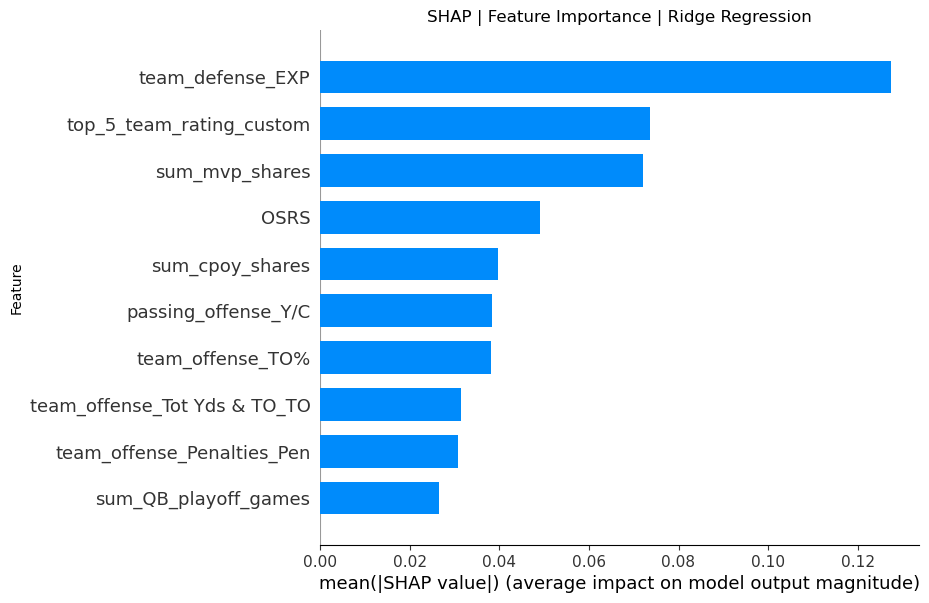

In [33]:

explainer = shap.LinearExplainer(rig, train[features])
shap_values = explainer.shap_values(test[features])

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]

top_features_list = [features[index] for index in top_features]
print("Top 10 Features:")
print(top_features_list)

shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, plot_type="bar", show=False)
plt.gcf().set_size_inches(10, 6)
plt.title('SHAP | Feature Importance | Ridge Regression')

plt.savefig("ridge_shap_bar.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("ridge_shap_bar.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("ridge_shap_bar.png")

plt.ylabel("Feature")
plt.show()

Top 10 Features:
['team_defense_EXP', 'top_5_team_rating_custom', 'sum_mvp_shares', 'OSRS', 'sum_cpoy_shares', 'passing_offense_Y/C', 'team_offense_TO%', 'team_offense_Tot Yds & TO_TO', 'team_offense_Penalties_Pen', 'sum_QB_playoff_games']


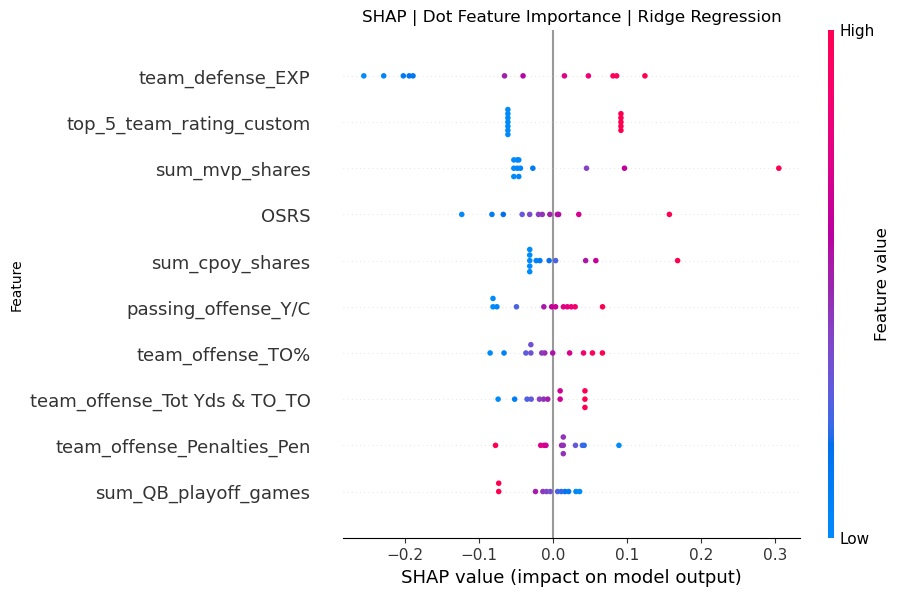

In [34]:
explainer = shap.LinearExplainer(rig, train[features])
shap_values = explainer.shap_values(test[features])

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]

top_features_list = [features[index] for index in top_features]
print("Top 10 Features:")
print(top_features_list)

shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Dot Feature Importance | Ridge Regression')

plt.savefig("rig_shap_dot.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("rig_shap_dot.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rig_shap_dot.png")

plt.ylabel("Feature")
plt.show()

Top 10 Features:
['sum_QB_playoff_games', 'sum_all_pro', 'sum_dpoy_shares', 'team_offense_Rushing_Y/A', 'sum_cpoy_shares', '40_50+_perc_x_makes', 'team_defense_Tot Yds & TO_Ply', 'top_5_team_rating_custom', 'team_offense_Penalties_1stPy', 'sum_champions']


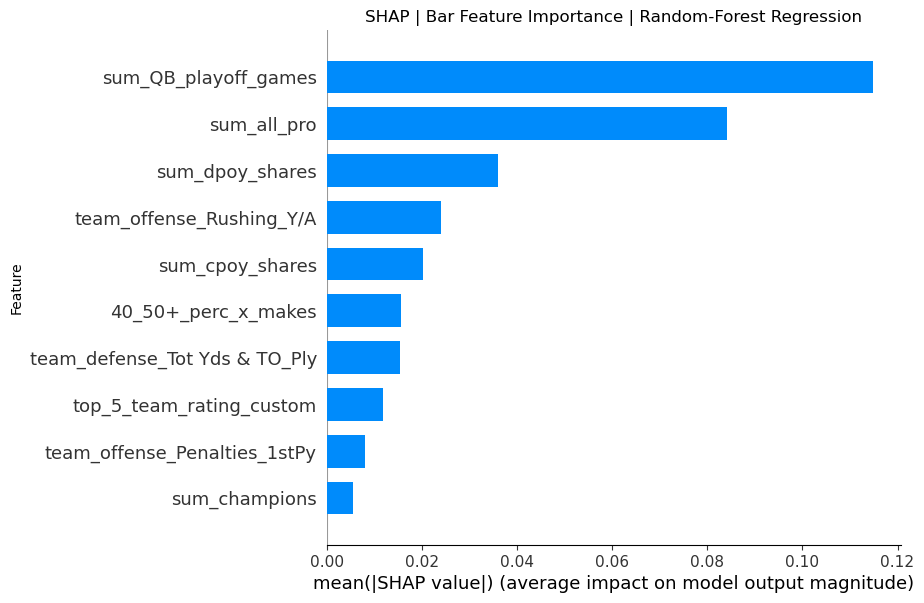

In [35]:
explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(test[features])

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]

top_features_list = [features[index] for index in top_features]
print("Top 10 Features:")
print(top_features_list)

shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, plot_type="bar", show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Bar Feature Importance | Random-Forest Regression')

plt.savefig("rf_shap_bar.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("rf_shap_bar.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rf_shap_bar.png")

plt.ylabel("Feature")
plt.show()

Top 10 Features:
['sum_QB_playoff_games', 'sum_all_pro', 'sum_dpoy_shares', 'team_offense_Rushing_Y/A', 'sum_cpoy_shares', '40_50+_perc_x_makes', 'team_defense_Tot Yds & TO_Ply', 'top_5_team_rating_custom', 'team_offense_Penalties_1stPy', 'sum_champions']


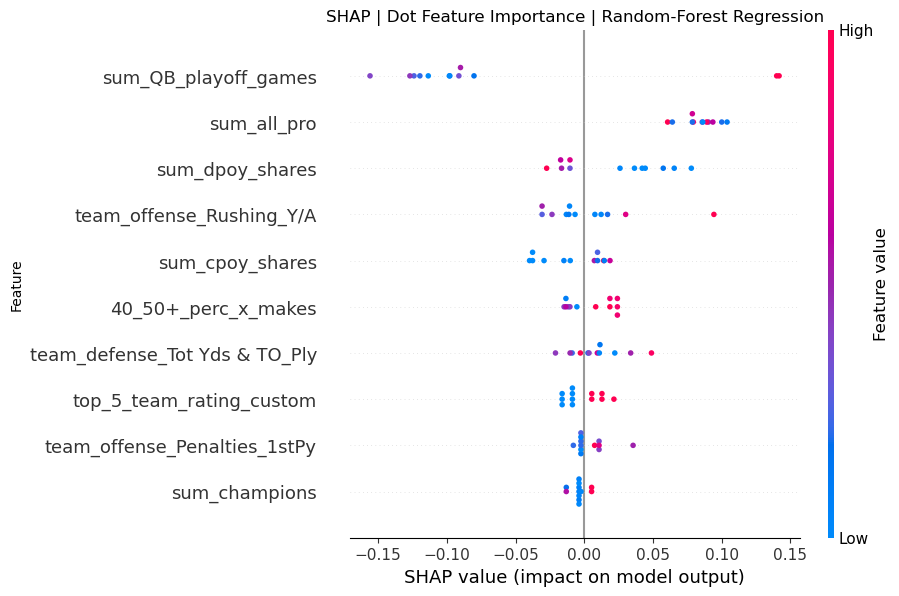

In [36]:

explainer = shap.Explainer(rf)
shap_values = explainer.shap_values(test[features])

feature_importance = np.abs(shap_values).mean(axis=0)
top_features = feature_importance.argsort()[::-1][:10]

top_features_list = [features[index] for index in top_features]
print("Top 10 Features:")
print(top_features_list)

shap_values_top = shap_values[:, top_features]
test_top_features = test[top_features_list]

shap.summary_plot(shap_values_top, test_top_features, feature_names=top_features_list, show=False)
plt.gcf().set_size_inches(10, 6)

plt.title('SHAP | Dot Feature Importance | Random-Forest Regression')

plt.savefig("rf_shap_dot.png", bbox_inches='tight', pad_inches=0.1)
image = Image.open("rf_shap_dot.png")
image_with_border = ImageOps.expand(image, border=2, fill='black')
image_with_border.save("rf_shap_dot.png")

plt.ylabel("Feature")
plt.show()